# Purpose:



## Imports:

In [209]:
import IPython
from ipy_progressbar import ProgressBar

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp

import mpld3
# mpld3.enable_notebook()

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from statsmodels.nonparametric.smoothers_lowess import lowess

import munch

import pymc as mc

from shapely.geometry import LineString

from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

from gs_ddRAD2015.scripts import ld_figures as ldfigs

In [ ]:
# set figure characteristics

# size
sns.set_context("poster")

# Grid style
sns.set_style("whitegrid")

# colors
sns.set_palette(sns.hls_palette(n_colors=5, h=0.59, l=0.4, s=0.75))

## File paths:

In [5]:
# define paths to files
out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/OT_MS_NB_indiv.geno.ld"

## Loading files

In [6]:
figs = ldfigs.Figures(out_dir=out_dir, formats='png')

In [7]:
figs.load_data_tables()


ld_figures: loading data_tables.




In [8]:
tables = munch.Munch(figs.d)
tables.keys()

['ld',
 'd_bins',
 'contig_info',
 'd_bin_v_others_melt',
 'len_contigs_per_bin',
 'd_bin_v_others',
 'contigs_per_bin',
 'mean_bin_r2_all',
 'sp_contigs',
 'ld_contig']

In [9]:
ld = tables.ld
ld.head()

,Unnamed: 0,Unnamed: 0.1,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,0,0,Scaffold0,13388,23408,48,1.000000,10020,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
1,1,1,Scaffold0,13388,23418,48,1.000000,10030,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
2,2,2,Scaffold0,13388,23421,48,1.000000,10033,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
3,3,3,Scaffold0,13388,23431,48,0.975315,10043,10000,0.974840,NaN,NaN,0.999662,0.000338,NaN,False
4,4,4,Scaffold0,13388,30544,49,0.366428,17156,17150,0.366562,NaN,NaN,0.862496,0.137504,NaN,False


In [10]:
def get_halfing_coords(xs, ys, num, tolerance):
    xs_return = []
    ys_return = []
    
    halfing_values = get_n_halfing_values(val=ys[0],n=num)[1:]
    
    for value in halfing_values:
        indexes_close_to_yi = get_indexes_close_to_yi(ys=ys, value=value, tolerance=tolerance)
        middle_item = get_first_item(indexes=indexes_close_to_yi)
        if middle_item is None:
            print 'None'
        else:
            # print indexes_close_to_yi
            # print xs[middle_item]
            # print ys[middle_item]
            xs_return.append(xs[middle_item])
            ys_return.append(ys[middle_item])
    
    return xs_return,ys_return
    
def get_indexes_close_to_yi(ys, value, tolerance):
    ilist = []
    for i,y in enumerate(ys):
        if abs(value-y) <= tolerance:
            ilist.append(i)
    return ilist
    
def get_n_halfing_values(val, n):
    rvalues = []
    c_val = val
    for i in range(n+1):
        c_val = c_val/2.0
        rvalues.append(c_val)
    return rvalues
        
def get_middle_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[int(len(indexes)/2)]

def get_first_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[0]

# Distance bt snp-pair vs R^2 all:

In [11]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [12]:
d_bin_v_others_melt = figs.d.d_bin_v_others_melt

In [40]:
# mpld3.enable_notebook()
# mpld3.disable_notebook()

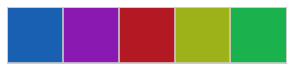

In [191]:
# pal = sns.choose_colorbrewer_palette("q")

# pal = sns.husl_palette(n_colors=4, h=0.6, s=0.9, l=0.65)
# pal = sns.hls_palette(n_colors=5, h=0.59, l=0.4, s=0.75)
# sns.palplot(pal)

# pal = sns.choose_cubehelix_palette()

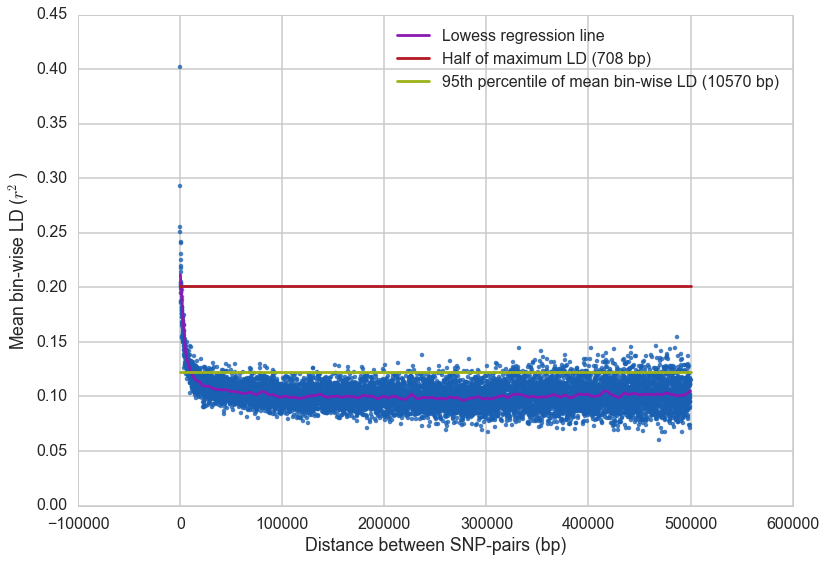

In [196]:
# sns.set_palette(pal)

melted_r2 = d_bin_v_others_melt.query("variable == 'R2'").query("0 <= distance_bin <= 00000")

d = melted_r2.distance_bin

r2 = melted_r2.value
r2_95centile = r2.quantile(.95)

rgplt = sns.regplot(d, r2, data=None, x_estimator=None, x_bins=None, x_ci=95, 
            scatter=True, fit_reg=False, ci=95, n_boot=10000, 
            units=None, order=1, logistic=False, lowess=True, robust=False, 
            logx=False, x_partial=None, y_partial=None, 
            truncate=False, dropna=True, x_jitter=None, y_jitter=None, 
            xlabel=None, ylabel=None, label=None, 
            color=None, marker='o', 
            scatter_kws=None, line_kws=None, ax=None)

# plt.plot(d,
#          movingaverage(interval=r2, window_size=6),
#          color='coral', alpha=0.3);

# lowess regression
delta = 0.01 * len(d)
r2_lowess = lowess(r2,d,frac=0.02, it=0, delta=delta)
r2_half = r2.max()/2.


centile_line = [[0,r2_95centile],[r2_lowess[-1][0],r2_95centile]]
halfing_line = [[0,r2_half],[r2_lowess[-1][0],r2_half]]

halfing_geo = LineString(halfing_line)
centile_geo = LineString(centile_line)
lowess_geo = LineString(r2_lowess)

isect_c = centile_geo.intersection(lowess_geo)
isect_h = halfing_geo.intersection(lowess_geo)

isect_c_x,isect_c_y = int(round(isect_c.x)), isect_c.y
isect_h_x,isect_h_y = int(round(isect_h.x)), isect_h.y

plt.plot(d,
         r2_lowess[:,1],
         alpha=1,
         label="Lowess regression line");

plt.plot([x[0] for x in halfing_line],
         [y[1] for y in halfing_line],  
         label=u"Half of maximum LD ({isect} bp)".format(isect=isect_h_x),
         alpha=1
        );

plt.plot([x[0] for x in centile_line],
         [y[1] for y in centile_line], 
         label="95th percentile of mean bin-wise LD ({isect} bp)".format(isect=isect_c_x),
         alpha=1
        );




# plt.plot(0,0,label="test3",alpha=0)

# plt.scatter(x=xs_hlf, y=ys_hlf, 
#             s=200, c=u'k', marker=u'x', 
#             alpha=None, linewidths=2);

plt.xlabel(r"Distance between SNP-pairs (bp)");
plt.ylabel(r"Mean bin-wise LD ($r^2$)");



plt.legend()

# print "xs_hlf, ys_hlf: ",xs_hlf, ys_hlf 



# Describe number of SNP-pairs that pass bin filtering and distance pattern (if any) 

In [197]:
ld.one_minus_cdf_BH.unique()

array([             nan,   4.33265264e-04,   9.32948997e-01, ...,
         2.41107259e-01,   5.01827111e-01,   4.37354874e-02])

Because the above has 'nan' values, I am recalculating the BH corrections.

### BH corrections

In [210]:
pb = ProgressBar(10, title='Outer', key='outer')
for i in pb:
    pb_inner = ProgressBar(5, title='Inner', key='inner')
    for j in pb_inner:
        pass


Outer:   0% [                                     ] 0/10 [0.0 s] [eta nan+-nan s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  10% [████                                     ] 1/10 [0.0 s] [eta 0+-0 s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  20% [████████                                 ] 2/10 [0.0 s] [eta 0+-0 s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  30% [████████████                             ] 3/10 [0.0 s] [eta 0+-0 s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  40% [████████████████                         ] 4/10 [0.0 s] [eta 0+-0 s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  50% [████████████████████                     ] 5/10 [0.0 s] [eta 0+-0 s]
Inner: 100% [█████████████████████████████████████████] 5/5 [0.0 s] [eta 0+-0 s]
Outer:  60% [████████

In [ ]:
for idx,bin_id in enumerate(list(ld.distance_bin.unique())):
    
    if idx%100 == 0:
        print idx
    bin_mask = ld.distance_bin == bin_id
    ld.loc[bin_mask, 'one_minus_cdf_BH'] = smm.multipletests(ld[bin_mask].one_minus_cdf,
                                                             method='fdr_bh')[1]

0
100
200
300
400
500

In [ ]:
ld.one_minus_cdf_BH.unique()

-------------------

# Misc

In [52]:
def get_melted_by_scaff(df,scaff_name):
    df_scaf = df.query("CHR_A == '{scaff_name}'".format(scaff_name=scaff_name)).pivot_table(index=['distance_bin'],
                                               values=['R2'],
                                               aggfunc=[np.mean]
                                               )['mean'].reset_index()
    return pd.melt(df_scaf, id_vars=['distance_bin'])

In [55]:
melted_scaf0 = get_melted_by_scaff(ld,'Scaffold0')
melted_scaf0.head()

,distance_bin,variable,value
0,0,R2,0.560982
1,50,R2,0.308072
2,100,R2,0.514498
3,150,R2,0.009752
4,200,R2,0.468399


### From https://fabiomarroni.wordpress.com/2011/08/09/estimate-decay-of-linkage-disequilibrium-with-distance/

In [203]:
import rpy2.robjects as robjects